# Determine accuracy of planet coordinates

This notebook empirically determines the accuracy of two functions, 
comparing to the "gold standard" of JPL Horizons:

- `get_planet_chandra`: uses DE432 + OFLS Chandra ephemeris to compute relative to Chandra
- `get_planet_eci`: uses DE432 and computes relative to Earth

## `get_planet_chandra` errors

- Venus: < 0.25 arcsec with a peak around 0.02
- Mars: < 0.45 arcsec with a peak around 0.1
- Jupiter: < 0.2 arcsec with a peak around 0.1
- Saturn: < 0.2 arcsec with a peak around 0.1

## `get_planet_eci` errors

The larger errors are due to ignoring the Chandra orbit.

- Venus: < 12 arcmin with peak around 2 arcmin
- Mars: < 8 arcmin with peak around 1.5 arcmin
- Jupiter: < 1 arcmin with peak around 0.5 arcmin
- Saturn: < 0.5 arcmin with peak around 0.3 arcmin

In [1]:
from chandra_aca.planets import (
    get_planet_chandra,
    get_planet_barycentric,
    get_planet_eci,
    get_planet_chandra_horizons,
)
from chandra_aca.transform import eci_to_radec
from agasc import sphere_dist
import matplotlib.pyplot as plt
from functools import lru_cache

%matplotlib inline

In [2]:
# @lru_cache
def compare_methods(body, start="2010:001", stop="2021:001", n_times=1000):
    pos = get_planet_chandra_horizons(body, start, stop, n_times=n_times)
    pos["err-ephem"] = 0.0
    pos["err-earth"] = 0.0

    eci = get_planet_eci(body, pos["time"])
    body_ra, body_dec = eci_to_radec(eci)
    pos["err-earth"] = sphere_dist(pos["ra"], pos["dec"], body_ra, body_dec) * 3600

    eci = get_planet_chandra(body, pos["time"])
    body_ra, body_dec = eci_to_radec(eci)
    pos["err-ephem"] = sphere_dist(pos["ra"], pos["dec"], body_ra, body_dec) * 3600

    return pos

In [3]:
def plot_errors(body, n_times=1000, save=False):
    pos = compare_methods(body, start="2010:001", stop="2021:001", n_times=n_times)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
    ax1.hist(pos["err-ephem"], bins=50)
    ax1.set_title(f"{body} get_planet_chandra errors")
    ax1.set_xlabel("arcsec")
    ax2.hist(pos["err-earth"], bins=50)
    ax2.set_title(f"{body} get_planet_eci errors")
    ax2.set_xlabel("arcsec")
    if save:
        plt.savefig(f"planet-errors-{body}.png")

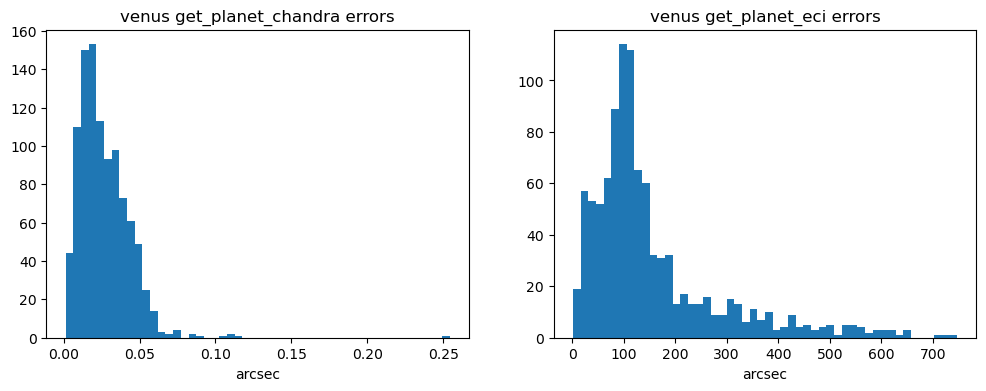

In [4]:
plot_errors("venus", n_times=1000)

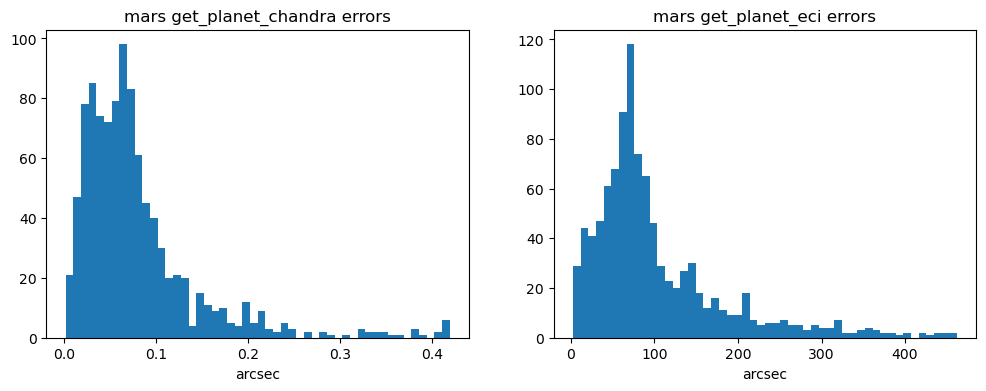

In [5]:
plot_errors("mars", n_times=1000)

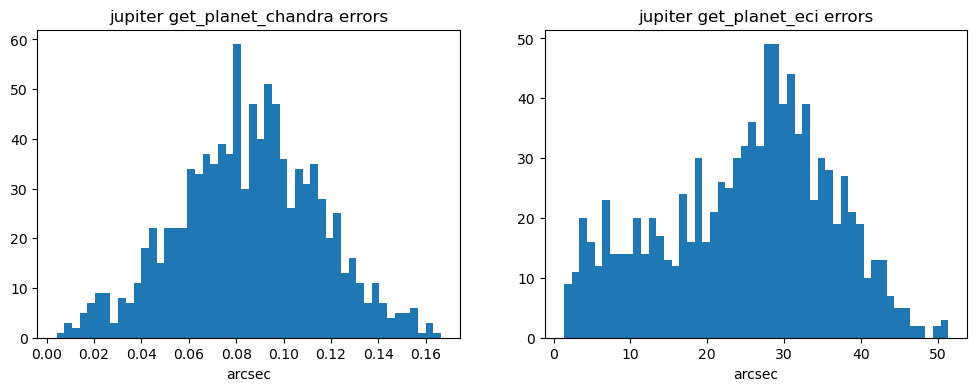

In [6]:
plot_errors("jupiter", n_times=1000)

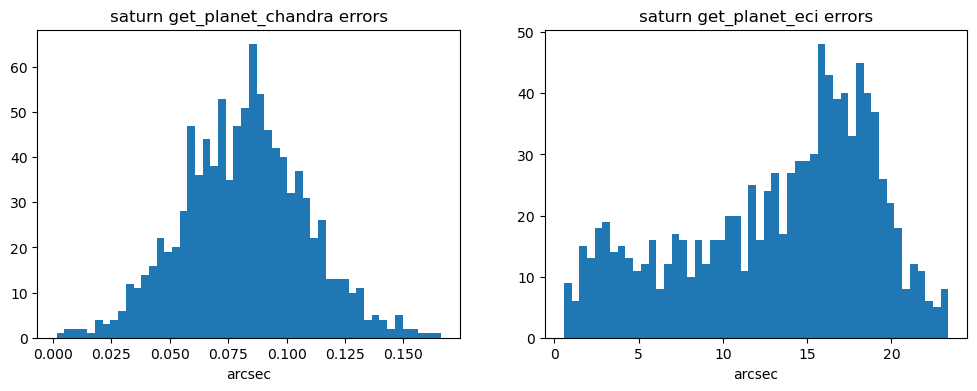

In [7]:
plot_errors("saturn", n_times=1000)